In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video object segmentation with SAM 3

This notebook shows how to use SAM 3 for video object segmentation in videos, illustrating the use of the  `Sam3TrackerPredictor` class.


This notebook follows the SAM 2 API for interactive video segmentation.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_for_sam2_video_task_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

First install `sam3` in your environment using the [installation instructions](https://github.com/facebookresearch/sam3?tab=readme-ov-file#installation) in the repository.

## Set-up

In [1]:
import torch

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 3 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [2]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

import sam3
import torch
from PIL import Image
from sam3.visualization_utils import show_box, show_mask, show_points

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")

### Loading the SAM 3 tracking predictor

In [3]:
from sam3.model_builder import build_sam3_video_model

sam3_model = build_sam3_video_model()
predictor = sam3_model.tracker
predictor.backbone = sam3_model.detector.backbone

INFO 2025-11-20 20:33:49,001 114321 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16


#### Initialize the inference state

Just like SAM 2, SAM 3 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [4]:
video_path = f"{sam3_root}/assets/videos/bedroom.mp4"
inference_state = predictor.init_state(video_path=video_path)

### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `clear_all_points_in_video`.

(The cell below is just for illustration; it's not needed to call `clear_all_points_in_video` here as this `inference_state` is just freshly initialized above.)

In [5]:
predictor.clear_all_points_in_video(inference_state)

#### Step 1: Add a first click on a frame

To get started, let's try to segment the child on the left.

Here we make a **positive click** at (x, y) = (210, 350) with label `1`, by sending their coordinates and labels into the `add_new_points` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

In [6]:
# load the frames for visualization
cap = cv2.VideoCapture(video_path)
video_frames_for_vis = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cap.release()
frame0 = video_frames_for_vis[0]

width, height = frame0.shape[1], frame0.shape[0]

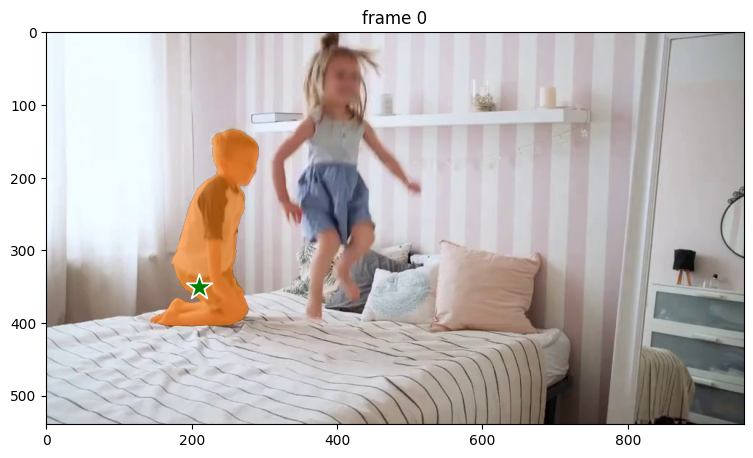

In [7]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)

rel_points = [[x / width, y / height] for x, y in points]

points_tensor = torch.tensor(rel_points, dtype=torch.float32)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

_, out_obj_ids, low_res_masks, video_res_masks = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_tensor,
    labels=points_labels_tensor,
    clear_old_points=False,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame0)
show_points(points, labels, plt.gca())
show_mask((video_res_masks[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: Add a second click to refine the prediction

Hmm, it seems that although we wanted to segment the child on the left, the model predicts the mask for only the shorts -- this can happen since there is ambiguity from a single click about what the target object should be. We can refine the mask on this frame via another positive click on the child's shirt.

Here we make a **second positive click** at (x, y) = (250, 220) with label `1` to expand the mask.

Note: we need to send **all the clicks and their labels** (i.e. not just the last click) when calling `add_new_points`.

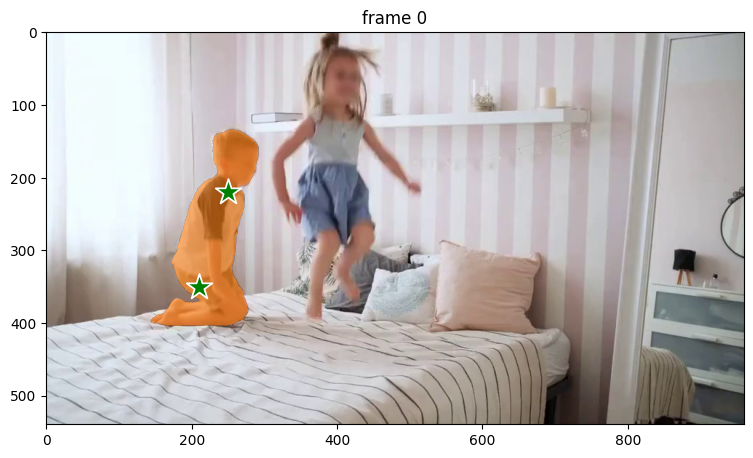

In [8]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[210, 350], [250, 220]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)

rel_points = [[x / width, y / height] for x, y in points]

points_tensor = torch.tensor(rel_points, dtype=torch.float32)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

_, out_obj_ids, low_res_masks, video_res_masks  = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_tensor,
    labels=points_labels_tensor,
    clear_old_points=False,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame0)
show_points(points, labels, plt.gca())
show_mask((video_res_masks[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

With this 2nd refinement click, now we get a segmentation mask of the entire child on frame 0.

#### Step 3: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

propagate in video:   0%|          | 0/200 [00:00<?, ?it/s]

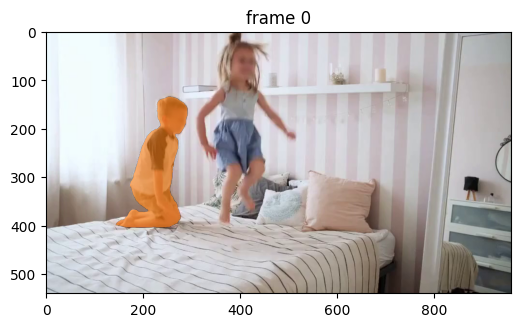

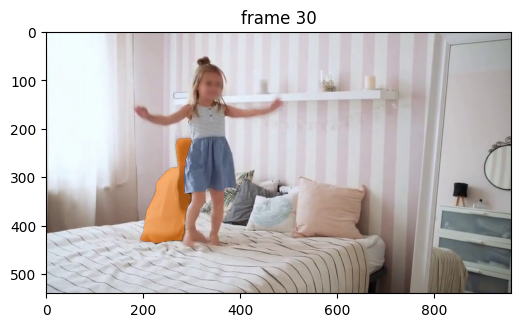

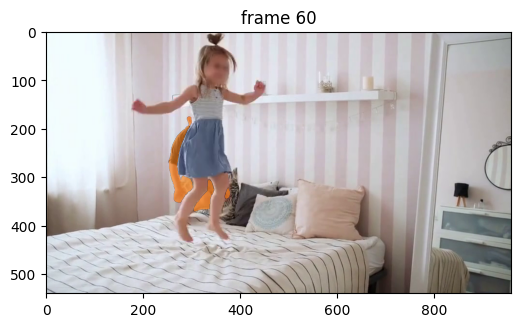

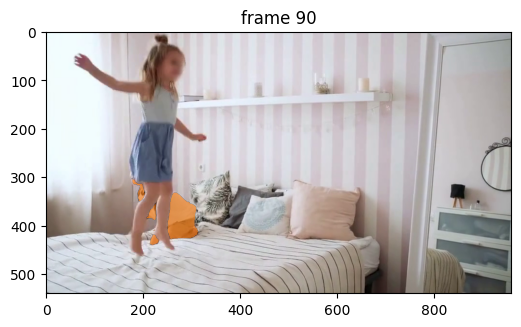

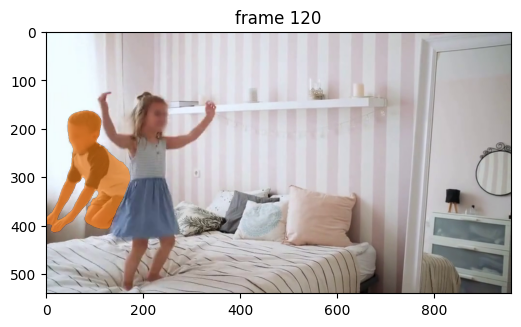

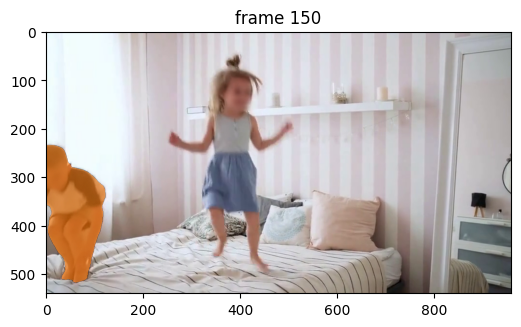

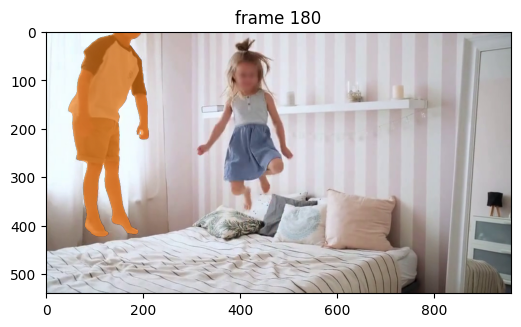

In [9]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for frame_idx, obj_ids, low_res_masks, video_res_masks, obj_scores in predictor.propagate_in_video(inference_state, start_frame_idx=0, max_frame_num_to_track=240, reverse=False, propagate_preflight=True):
    video_segments[frame_idx] = {
        out_obj_id: (video_res_masks[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(video_frames_for_vis), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(video_frames_for_vis[out_frame_idx])
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

#### Step 4: Add new prompts to further refine the masklet

It appears that in the output masklet above, there are some small imperfections in boundary details on frame 150.

With SAM 3 we can fix the model predictions interactively. We can add a **negative click** at (x, y) = (82, 415) on this frame with label `0` to refine the masklet. Here we call the `add_new_points_or_box` API with a different `frame_idx` argument to indicate the frame index we want to refine.

In [ ]:
ann_frame_idx = 150  # further refine some details on this frame
ann_obj_id = 1  # give a unique id to the object we interact with (it can be any integers)

# show the segment before further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- before refinement")
plt.imshow(video_frames_for_vis[ann_frame_idx])
show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# Let's add a negative click on this frame at (x, y) = (82, 415) to refine the segment
points = np.array([[82, 410]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([0], np.int32)

rel_points = [[x / width, y / height] for x, y in points]

points_tensor = torch.tensor(rel_points, dtype=torch.float32)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

_, out_obj_ids, low_res_masks, video_res_masks  = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_tensor,
    labels=points_labels_tensor,
    clear_old_points=False,
)


# show the segment after the further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- after refinement")
plt.imshow(video_frames_for_vis[ann_frame_idx])
show_points(points, labels, plt.gca())
show_mask((video_res_masks > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

#### Step 5: Propagate the prompts (again) to get the masklet across the video

Let's get an updated masklet for the entire video. Here we call `propagate_in_video` again to propagate all the prompts after adding the new refinement click above.

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for frame_idx, obj_ids, low_res_masks, video_res_masks, obj_scores in predictor.propagate_in_video(inference_state, start_frame_idx=0, max_frame_num_to_track=300, reverse=False, propagate_preflight=True):
    video_segments[frame_idx] = {
        out_obj_id: (video_res_masks[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(video_frames_for_vis), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(video_frames_for_vis[out_frame_idx])
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

The segments now look good on all frames.

### Example 2: Segment an object using box prompt

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `clear_all_points_in_video`.

In [ ]:
predictor.clear_all_points_in_video(inference_state)

In addition to using clicks as inputs, SAM 3 also supports segmenting and tracking objects in a video via **bounding boxes**.

In the example below, we segment the child on the right using a **box prompt** of (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) on frame 0 as input into the `add_new_points_or_box` API.

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = np.array([[300, 0, 500, 400]], dtype=np.float32)

rel_box = [[xmin / width, ymin / height, xmax / width, ymax / height] for xmin, ymin, xmax, ymax in box]
rel_box = np.array(rel_box, dtype=np.float32)

_, out_obj_ids, low_res_masks, video_res_masks  = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=rel_box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(video_frames_for_vis[ann_frame_idx])
show_box(box[0], plt.gca())
show_mask((video_res_masks[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

Here, SAM 3 gets a pretty good segmentation mask of the entire child, even though the input bounding box is not perfectly tight around the object.

Similar to the previous example, if the returned mask from is not perfect when using a box prompt, we can also further **refine** the output using positive or negative clicks. To illustrate this, here we make a **positive click** at (x, y) = (460, 60) with label `1` to expand the segment around the child's hair.

Note: to refine the segmentation mask from a box prompt, we need to send **both the original box input and all subsequent refinement clicks and their labels** when calling `add_new_points_or_box`.

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (460, 60) to refine the mask
points = np.array([[460, 60]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
# note that we also need to send the original box input along with
# the new refinement click together into `add_new_points_or_box`
box = np.array([[300, 0, 500, 400]], dtype=np.float32)

rel_box = [[xmin / width, ymin / height, xmax / width, ymax / height] for xmin, ymin, xmax, ymax in box]
rel_box = np.array(rel_box, dtype=np.float32)

rel_points = [[x / width, y / height] for x, y in points]

points_tensor = torch.tensor(rel_points, dtype=torch.float32)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

_, out_obj_ids, low_res_masks, video_res_masks  = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_tensor,
    labels=points_labels_tensor,
    box=rel_box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(video_frames_for_vis[ann_frame_idx])
show_box(box[0], plt.gca())
show_points(points, labels, plt.gca())
show_mask((video_res_masks[0][0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

Then, to get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for frame_idx, obj_ids, low_res_masks, video_res_masks, obj_scores in predictor.propagate_in_video(inference_state, start_frame_idx=0, max_frame_num_to_track=300, reverse=False, propagate_preflight=True):
    video_segments[frame_idx] = {
        out_obj_id: (video_res_masks[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(video_frames_for_vis), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(video_frames_for_vis[out_frame_idx])
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

Note that in addition to clicks or boxes, SAM 3 also supports directly using a **mask prompt** as input via the `add_new_mask` method in the `Sam3TrackerPredictor` class. This can be helpful in e.g. semi-supervised VOS evaluations (see [tools/vos_inference.py](https://github.com/facebookresearch/sam2/blob/main/tools/vos_inference.py) for an example).

### Example 3: Segment multiple objects simultaneously

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `clear_all_points_in_video`.

In [ ]:
predictor.clear_all_points_in_video(inference_state)

#### Step 1: Add two objects on a frame

SAM 3 can also segment and track two or more objects at the same time. One way, of course, is to do them one by one. However, it would be more efficient to batch them together (e.g. so that we can share the image features between objects to reduce computation costs).

This time, let's focus on object parts and segment **the shirts of both childen** in this video. Here we add prompts for these two objects and assign each of them a unique object id.

In [ ]:
prompts = {}  # hold all the clicks we add for visualization

Add the first object (the left child's shirt) with a **positive click** at (x, y) = (200, 300) on frame 0.

We assign it to object id `2` (it can be arbitrary integers, and only needs to be unique for each object to track), which is passed to the `add_new_points_or_box` API to distinguish the object we are clicking upon.

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (200, 300) to get started on the first object
points = np.array([[200, 300]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels

rel_points = [[x / width, y / height] for x, y in points]
points_tensor = torch.tensor(rel_points, dtype=torch.float32)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

_, out_obj_ids, low_res_masks, video_res_masks = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_tensor,
    labels=points_labels_tensor,
)


# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(video_frames_for_vis[ann_frame_idx])
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(points, labels, plt.gca())
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((video_res_masks[i][0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

Hmm, this time we just want to select the child's shirt, but the model predicts the mask for the entire child. Let's refine the prediction with a **negative click** at (x, y) = (275, 175).

In [ ]:
# add the first object
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd negative click at (x, y) = (275, 175) to refine the first object
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[200, 300], [275, 175]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels

rel_points = [[x / width, y / height] for x, y in points]
points_tensor = torch.tensor(rel_points, dtype=torch.float32)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)


_, out_obj_ids, low_res_masks, video_res_masks  = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=rel_points,
    labels=points_labels_tensor,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(video_frames_for_vis[ann_frame_idx])
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(points, labels, plt.gca())
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((video_res_masks[i][0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

After the 2nd negative click, now we get the left child's shirt as our first object.

Let's move on to the second object (the right child's shirt) with a positive click at (x, y) = (400, 150) on frame 0. Here we assign object id `3` to this second object (it can be arbitrary integers, and only needs to be unique for each object to track).

Note: when there are multiple objects, the `add_new_points_or_box` API will return a list of masks for each object.

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[400, 150]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels

rel_points = [[x / width, y / height] for x, y in points]
points_tensor = torch.tensor(rel_points, dtype=torch.float32)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)


# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, low_res_masks, video_res_masks = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_tensor,
    labels=points_labels_tensor,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(video_frames_for_vis[ann_frame_idx])
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(points, labels, plt.gca())
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((video_res_masks[i][0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

This time the model predicts the mask of the shirt we want to track in just one click. Nice!

#### Step 2: Propagate the prompts to get masklets across the video

Now, we propagate the prompts for both objects to get their masklets throughout the video.

Note: when there are multiple objects, the `propagate_in_video` API will return a list of masks for each object.

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for frame_idx, obj_ids, low_res_masks, video_res_masks, obj_scores in predictor.propagate_in_video(inference_state, start_frame_idx=0, max_frame_num_to_track=300, reverse=False, propagate_preflight=True):
    video_segments[frame_idx] = {
        out_obj_id: (video_res_masks[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(video_frames_for_vis), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(video_frames_for_vis[out_frame_idx])
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

Looks like both children's shirts are well segmented in this video.

Now you can try SAM 3 on your own videos and use cases! 